In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_images = 1
img_dim = 64 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 80
psf_stdev = 1
background_intensity = 19200

prior = CatalogPrior(max_objects = max_objects,
                     img_height = img_height,
                     img_width = img_width,
                     min_flux = background_intensity/3.)

image_attributes = ImageAttributes(img_height = img_height,
                                   img_width = img_width,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(prior, num_images)

image 1 
count
 80 
total flux
 4936792.5 
loc
 [[ 5.520816    5.8532414 ]
 [46.8804     63.451862  ]
 [26.582922   34.372803  ]
 [63.496937   17.303703  ]
 [36.906574   42.968178  ]
 [35.36972    25.056147  ]
 [ 4.212587   15.759312  ]
 [ 8.822884   19.507607  ]
 [14.352716   30.947414  ]
 [44.75681    38.7628    ]
 [15.391516   61.520027  ]
 [43.772175   29.890059  ]
 [21.555786   51.640938  ]
 [34.855      17.18437   ]
 [10.106801    2.9610767 ]
 [45.437004   57.575447  ]
 [14.8152895   0.6507088 ]
 [18.587025   18.339804  ]
 [31.277592   35.98682   ]
 [ 4.949513   19.574566  ]
 [19.249668   22.327883  ]
 [56.053066   21.848057  ]
 [ 7.7471547  50.992813  ]
 [61.41995     5.2547455 ]
 [46.137333   18.612541  ]
 [ 1.0052184   6.912592  ]
 [ 5.5329747  51.42247   ]
 [ 4.117388   26.932093  ]
 [ 5.230475   29.71815   ]
 [47.20956    31.096195  ]
 [13.331853   61.869152  ]
 [55.588116   41.761322  ]
 [48.11779    18.079708  ]
 [ 0.70751274 17.886171  ]
 [49.544136    9.890984  ]
 [56.72

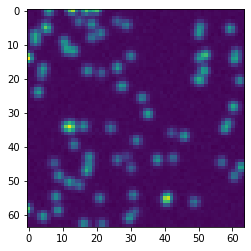

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

In [4]:
tile_side_length = 4
max_objects_smc = 2
pad = 2

prior = CatalogPrior(max_objects_smc,
                     img_width, img_height,
                     background_intensity/3.,
                     pad)

smc = SMCsampler(images[0], image_attributes, tile_side_length, prior,
                 max_objects = max_objects_smc, catalogs_per_block = 500,
                 kernel_num_iters = 100, product_form_multiplier = 250,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 80
True total flux: 4936792.5

Starting the tile samplers...
iteration 5, temperature = 0.001518210512585938
iteration 10, temperature = 0.009848058223724365
iteration 15, temperature = 0.037124671041965485
iteration 20, temperature = 0.16590064764022827
iteration 25, temperature = 0.9678134918212891
Done!

Combining the results...
Done!

Pruning detections...
Done!

summary
number of SMC iterations: 25
posterior mean count: 80.65471649169922
posterior mean total flux: 4762629.5



